# Coefficient Estimation for NEWT

The optimal model involves eight seasonality coefficients and a baseline air temperature sensitivity, a total of nine terms.  We don't need to estimate anything for the relationship between seasonal temperature and sensitivity on a given day, since a global GAM does that.  So we have nine coefficients to estimate.

However, those nine coefficients are correlated, which raises problems for uncertainty analysis and, in general, suggests inefficiency.  So the first thing we're going to do is principle component analysis on the coefficients.

This version of the Notebook implements specialized coefficient estimation for dry/wet years compared to the baseline for each site. We want to predict each coefficient (for a year) in terms of the overall coefficients and the year's mean air temperature and precip, running for water years.

Experiments:

- Whole-year-of, anomaly ~ anomaly only can do 30% for Intercept anomaly, but much worse (<10%) for the rest.
- Previous-year has awful performance for everything.
- Adding both early-year anomalies and baseline coefficients - anomaly ~ (year anom, early year anom, baseline coefs) - gets everything except sensitivity up over 10%, but still nothing reaches 40%. Baseline is usually more important, but early-anom can make a nontrivial contribution. Intercept and WinterDay are in the high 20s to high 30s and sensitivity is at 5, while the rest get 10-15%.
- Timing of "early-year" is highly sensitive. Anomaly nearly doubled in skill when switching from Oct-May to Dec-April.

From experiments to date, it may be worth modeling Intercept, Amplitude, and WinterDay, which all hit the 30%+ range. All are at least a bit nonlinear, especially Amplitude. However, a nonlinear approach with complex inputs produces excessively noisy predictions, resulting in degraded performance.

Another approach, then, is to brute-force a linear model of all monthly anomalies and baselines. To do that, we will run a PCA on the inputs.

In [1]:
import pandas as pd
import pandas.plotting as pdp
import numpy as np
import matplotlib.pyplot as plt
import rtseason as rts
import seaborn as sns
import scipy
import os
from sklearn.decomposition import PCA
import pygam  # https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html
from pygam import LinearGAM, s, te, l, f
from NEWT import Watershed, kfold, perf_summary, statics, analysis, engines
from NEXT.coef_est import build_training_data
import NEXT.data as ndata
import NEWT
import NEXT
from math import ceil
anomweights = np.array([0.132, 0.401, 0.162, 0.119, 0.056, 0.13 ])
bp = "/scratch/dphilippus/notebooks/next_validation/"

ERROR 1: PROJ: proj_create_from_database: Open of /u/wy/ch/dphilippus/.conda/envs/next/share/proj failed


In [2]:
data = pd.read_csv(bp + "DevDataBuffers.csv", dtype={"id": "str"}, parse_dates=["date"])
data = data[(data["temperature"] > -0.5) & (data["temperature"] < 40)]
data

,id,date,temperature,prcp,srad,swe,tmax,tmin,vp,day,...,asp_north,asp_east,lat,lon,year,canopy,flowdir,frozen,cold_prcp,ws_canopy
0,13011820,2020-03-31,0.100000,17.110126,248.76216,NaN,1.795443,NaN,444.26370,91,...,0.003187,0.002841,43.807111,-110.178722,2020,29.173334,260.527706,False,0.000000,27.182915
1,13011820,2020-04-01,0.100000,7.202532,403.38873,NaN,0.030759,NaN,270.94354,92,...,0.003187,0.002841,43.807111,-110.178722,2020,29.173334,260.527706,False,0.000000,27.182915
2,13011820,2020-04-02,0.100000,2.167848,600.86993,NaN,-3.442405,NaN,132.77936,93,...,0.003187,0.002841,43.807111,-110.178722,2020,29.173334,260.527706,True,2.167848,27.182915
3,13011820,2020-04-03,0.100000,2.987468,509.44165,NaN,-2.238481,NaN,138.35303,94,...,0.003187,0.002841,43.807111,-110.178722,2020,29.173334,260.527706,True,2.987468,27.182915
4,13011820,2020-04-04,0.100000,6.021518,465.97583,NaN,3.509114,NaN,284.43704,95,...,0.003187,0.002841,43.807111,-110.178722,2020,29.173334,260.527706,False,0.000000,27.182915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2987895,03047000,2022-12-27,0.540625,0.000000,268.23563,NaN,-2.151775,NaN,207.79785,361,...,0.004324,0.003170,40.458889,-79.449444,2022,29.154762,12.102172,True,0.000000,55.414196
2987896,03047000,2022-12-28,0.407292,0.000000,279.93356,NaN,5.509683,NaN,310.02664,362,...,0.004324,0.003170,40.458889,-79.449444,2022,29.154762,12.102172,False,0.000000,55.414196
2987897,03047000,2022-12-29,0.428125,0.000000,290.53482,NaN,13.100331,NaN,354.31638,363,...,0.004324,0.003170,40.458889,-79.449444,2022,29.154762,12.102172,False,0.000000,55.414196
2987898,03047000,2022-12-30,0.661458,0.000000,285.53320,NaN,17.568270,NaN,512.88240,364,...,0.004324,0.003170,40.458889,-79.449444,2022,29.154762,12.102172,False,0.000000,55.414196


In [3]:
data.drop(columns="date").describe()

,temperature,prcp,srad,swe,tmax,tmin,vp,day,water,developed,...,slope,asp_north,asp_east,lat,lon,year,canopy,flowdir,cold_prcp,ws_canopy
count,2.987900e+06,2.987900e+06,2.987900e+06,578400.000000,2.987900e+06,1.433446e+06,2.987900e+06,2.987900e+06,2.987900e+06,2.987900e+06,...,2.987900e+06,2.987900e+06,2.987900e+06,2.987900e+06,2.987900e+06,2.987900e+06,2.987900e+06,2.987900e+06,2.987900e+06,2.986986e+06
mean,1.304480e+01,3.425176e+00,3.273382e+02,17.926649,1.688383e+01,5.062516e+00,9.831255e+02,1.872229e+02,1.268352e-02,1.478107e-01,...,1.884932e-03,7.355827e-03,-1.552842e-03,3.992888e+01,-9.565336e+01,2.016161e+03,3.147648e+01,1.888851e+02,1.473491e-01,4.173630e+01
std,7.778464e+00,8.017643e+00,1.310696e+02,49.761395,1.065262e+01,9.425389e+00,6.475989e+02,1.040032e+02,2.060045e-02,2.192455e-01,...,2.532902e-03,1.024769e-02,1.524831e-02,4.613372e+00,1.749465e+01,4.168676e+00,2.808762e+01,9.836393e+01,1.352327e+00,2.300219e+01
min,-4.989583e-01,0.000000e+00,1.599158e+01,0.000000,-2.844553e+01,-3.810106e+01,1.937390e+01,1.000000e+00,0.000000e+00,0.000000e+00,...,4.762368e-05,-1.538242e-02,-2.824883e-01,2.697500e+01,-1.243930e+02,2.004000e+03,0.000000e+00,5.787924e-01,0.000000e+00,4.107644e-02
25%,6.691667e+00,0.000000e+00,2.272068e+02,0.000000,8.669371e+00,-1.216429e+00,5.072167e+02,9.900000e+01,1.829815e-03,1.931167e-02,...,4.481627e-04,3.460877e-03,-2.773193e-03,3.731277e+01,-1.120107e+02,2.013000e+03,4.000000e+00,1.047749e+02,0.000000e+00,2.231672e+01
50%,1.255729e+01,0.000000e+00,3.281181e+02,0.000000,1.786824e+01,5.120216e+00,7.729694e+02,1.890000e+02,5.872330e-03,5.986721e-02,...,9.428893e-04,5.018477e-03,2.168743e-03,4.005460e+01,-8.861419e+01,2.017000e+03,2.404255e+01,1.992379e+02,0.000000e+00,4.210295e+01
75%,1.918229e+01,3.160186e+00,4.291651e+02,7.820107,2.572708e+01,1.199073e+01,1.328157e+03,2.770000e+02,1.551254e-02,1.489284e-01,...,2.337958e-03,8.388438e-03,3.922721e-03,4.325386e+01,-8.047256e+01,2.020000e+03,5.741737e+01,2.747320e+02,0.000000e+00,6.113925e+01
max,3.999688e+01,2.717640e+02,8.285261e+02,750.342160,4.495986e+01,2.819078e+01,3.693103e+03,3.650000e+02,2.316803e-01,9.849686e-01,...,3.008171e-02,2.041745e-01,1.524249e-02,4.899881e+01,-6.780389e+01,2.022000e+03,9.486487e+01,3.586496e+02,8.861503e+01,8.766909e+01


## Prepare Coefficients

In [4]:
data["year"] = data["date"].dt.year + (data["date"].dt.month > 9) # water year
data

,id,date,temperature,prcp,srad,swe,tmax,tmin,vp,day,...,asp_north,asp_east,lat,lon,year,canopy,flowdir,frozen,cold_prcp,ws_canopy
0,13011820,2020-03-31,0.100000,17.110126,248.76216,NaN,1.795443,NaN,444.26370,91,...,0.003187,0.002841,43.807111,-110.178722,2020,29.173334,260.527706,False,0.000000,27.182915
1,13011820,2020-04-01,0.100000,7.202532,403.38873,NaN,0.030759,NaN,270.94354,92,...,0.003187,0.002841,43.807111,-110.178722,2020,29.173334,260.527706,False,0.000000,27.182915
2,13011820,2020-04-02,0.100000,2.167848,600.86993,NaN,-3.442405,NaN,132.77936,93,...,0.003187,0.002841,43.807111,-110.178722,2020,29.173334,260.527706,True,2.167848,27.182915
3,13011820,2020-04-03,0.100000,2.987468,509.44165,NaN,-2.238481,NaN,138.35303,94,...,0.003187,0.002841,43.807111,-110.178722,2020,29.173334,260.527706,True,2.987468,27.182915
4,13011820,2020-04-04,0.100000,6.021518,465.97583,NaN,3.509114,NaN,284.43704,95,...,0.003187,0.002841,43.807111,-110.178722,2020,29.173334,260.527706,False,0.000000,27.182915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2987895,03047000,2022-12-27,0.540625,0.000000,268.23563,NaN,-2.151775,NaN,207.79785,361,...,0.004324,0.003170,40.458889,-79.449444,2023,29.154762,12.102172,True,0.000000,55.414196
2987896,03047000,2022-12-28,0.407292,0.000000,279.93356,NaN,5.509683,NaN,310.02664,362,...,0.004324,0.003170,40.458889,-79.449444,2023,29.154762,12.102172,False,0.000000,55.414196
2987897,03047000,2022-12-29,0.428125,0.000000,290.53482,NaN,13.100331,NaN,354.31638,363,...,0.004324,0.003170,40.458889,-79.449444,2023,29.154762,12.102172,False,0.000000,55.414196
2987898,03047000,2022-12-30,0.661458,0.000000,285.53320,NaN,17.568270,NaN,512.88240,364,...,0.004324,0.003170,40.458889,-79.449444,2023,29.154762,12.102172,False,0.000000,55.414196


In [5]:
def make_local_coeff(grp, anomilized, yr=None):
    # Make year-specific coefficients using data and a preset year.
    if yr is None:
        if len(grp["day"].unique()) < 181:
            return None
        X = anomilized.loc[:, "delta0":"delta5"]
        y = anomilized["st_anom"]
        prd = X @ anomweights
        ssn = rts.ThreeSine.from_data(grp[["day", "temperature"]]).to_df().drop(columns=["RMSE", "R2"])
        ssn["sensitivity"] = y.abs().mean() / prd.abs().mean()
        return ssn[["Intercept", "Amplitude", "SpringSummer", "FallWinter", "WinterDay", "sensitivity"]]
    grp = grp.loc[grp["year"] == yr]
    anomilized = anomilized.loc[anomilized["year"] == yr]
    # Use existing logic for a single year
    res = make_local_coeff(grp, anomilized, None)
    if res is not None:
        res["year"] = yr
    return res

def make_coefficients(grp, byyr=True):
    if len(grp["day"].unique()) < 181:
        return None
    if len(grp) < 730:
        return None
    anomilized = NEWT.watershed.anomilize(grp).sort_values("date")[["date", "st_anom", "at_anom", "year"]]  # st_anom, at_anom
    for i in range(6):
        anomilized[f"delta{i}"] = anomilized["at_anom"].shift(i)
    anomilized = anomilized.dropna()
    ref = make_local_coeff(grp, anomilized, None)
    if not byyr:
        return ref
    bits = [make_local_coeff(grp, anomilized, year) for year in grp["year"].unique()]
    if all([b is None for b in bits]):
        return None
    yrs = pd.concat(bits)
    res = yrs - ref
    res["year"] = yrs["year"]
    return res.merge(ref.rename(columns=lambda x: x + "_ref"), how="cross").set_index("year")

Change vs baseline notes:

- Intercept: possible range $\pm$6, IQR $\pm$0.4 compared to base IQR of 5. Symmetrical with a small range.
- Amplitude: possible -13 to +6, IQR $\pm$0.4 compared to base IQR 4. Somewhat left-skewed with a small range.
- SpringSummer: possible -12 to +5, IQR -0.2 to +0.7 compared to base IQR 1.3. Nonzero median shift. Lumpy distribution with a large range.
- FallWinter: possible -4 to +6, IQR -0.3 to +0.6 compared to base IQR 1.2. Right-tending distribution with a large range.
- WinterDay: possible $\pm$109, IQR $\pm$10 compared to base IQR 60. Symmetrical with a modest range.
- Sensitivity: possible -0.7 to +1.7, IQR $\pm$0.05 compared to base IQR 0.2. A little right-skewed with a modest range.

In [6]:
coefs_yr = data.groupby("id").apply(make_coefficients, include_groups=False)#.droplevel(2)
# coefs = data.groupby("id").apply(lambda x: make_coefficients(x, False), include_groups=False).droplevel(1)
coefs_yr.describe()

,Amplitude,FallWinter,Intercept,SpringSummer,WinterDay,sensitivity,Intercept_ref,Amplitude_ref,SpringSummer_ref,FallWinter_ref,WinterDay_ref,sensitivity_ref
count,8234.000000,8234.000000,8234.000000,8234.000000,8234.000000,8234.000000,8234.000000,8234.000000,8234.000000,8234.000000,8234.000000,8234.000000
mean,0.001446,0.137870,0.015602,0.258818,-0.843211,0.003073,12.760922,8.692420,0.752381,1.408417,65.769917,0.585663
std,0.794945,0.758030,0.694818,0.773266,29.164963,0.092506,4.027080,2.815396,0.955484,0.938603,33.184701,0.155609
min,-12.983556,-4.231036,-6.034003,-11.983146,-109.000000,-0.650259,3.085846,0.182583,-2.585014,-2.453322,1.000000,0.072260
25%,-0.411661,-0.292733,-0.389356,-0.212854,-12.000000,-0.047607,9.903103,6.842084,0.038629,0.813096,32.000000,0.486919
50%,-0.001948,0.109838,0.033058,0.204619,0.000000,-0.002717,12.473657,9.121536,0.486446,1.409694,84.000000,0.590550
75%,0.416437,0.571068,0.391465,0.692690,9.000000,0.043899,15.122052,10.853771,1.297292,1.966065,90.000000,0.687392
max,5.991204,6.138540,5.886723,4.883538,109.000000,1.709365,30.100749,15.907383,4.922727,4.801733,110.000000,1.514792


In [7]:
coefs_yr

Amplitude  FallWinter  Intercept  SpringSummer  \
id              year                                                   
01010000        2013  -0.523222   -0.540827  -0.183049      0.290408   
                2014   0.152114    0.310228  -0.067034      0.199020   
                2015   0.343451    0.203889   0.251004      0.430718   
01011000        2011  -0.398255    0.014615  -0.581494      0.938985   
                2012   0.278617   -0.241342   0.624210     -0.738517   
...                         ...         ...        ...           ...   
453004122510301 2018  -0.138076    1.560369   0.136147      0.323443   
                2019   0.448157   -0.024682   0.147766     -0.200000   
                2020  -0.354094    0.467723   0.074132      0.561227   
                2021   0.575161    0.328937   0.845693     -0.061317   
                2022   0.618139   -0.672863   0.635013      1.965573   

                      WinterDay  sensitivity  Intercept_ref  Amplitude_ref  \
id              year                                                         
01010000        2013        0.0     0.026177       8.227527      11.664508   
                2014       -0.5     0.016199       8.227527      11.664508   
                2015        0.0    -0.079102       8.227527      11.664508   
01011000        2011        0.0     0.114244       8.547659      11.735706   
                2012        0.0    -0.078741       8.547659      11.735706   
...                         ...          ...            ...            ...   
453004122510301 2018      -59.0     0.074364      13.095366       7.200009   
                2019        3.0    -0.071707      13.095366       7.200009   
                2020       25.0     0.114515      13.095366       7.200009   
                2021       22.0     0.072769      13.095366       7.200009   
                2022       -1.0     0.112358      13.095366       7.200009   

                      SpringSummer_ref  FallWinter_ref  WinterDay_ref  \
id              year                                                    
01010000        2013          1.989669        3.269881           27.5   
                2014          1.989669        3.269881           27.5   
                2015          1.989669        3.269881           27.5   
01011000        2011          2.563314        2.746746           27.0   
                2012          2.563314        2.746746           27.0   
...                                ...             ...            ...   
453004122510301 2018          0.377075        1.749345           85.0   
                2019          0.377075        1.749345           85.0   
                2020          0.377075        1.749345           85.0   
                2021          0.377075        1.749345           85.0   
                2022          0.377075        1.749345           85.0   

                      sensitivity_ref  
id              year                   
01010000        2013         0.691518  
                2014         0.691518  
                2015         0.691518  
01011000        2011         0.564576  
                2012         0.564576  
...                               ...  
453004122510301 2018         0.688236  
                2019         0.688236  
                2020         0.688236  
                2021         0.688236  
                2022         0.688236  

[8234 rows x 12 columns]

When seasonality coefficients are near zero, dates are noisy, and we don't want that messing with our model, so we set days to their mean when the corresponding seasonal coefficient is low - "low" being below the 25th percentiles, which are 0.06 C for SpringSummer and 0.8 C for FallWinter.

## Predictors

In [33]:
data["month"] = data["date"].dt.month
inps = data.loc[:, ["id", "month", "year", "tmax", "prcp"]].groupby(["id", "month", "year"]).mean().reset_index()
inps = inps.pivot(index=["id", "year"], columns="month", values=["tmax", "prcp"])
inps.columns = ["_".join([str(s) for s in nms]) for nms in inps.columns.values]
means = inps.groupby("id").mean()
preds = (inps - means).reset_index().merge(means, suffixes=["_anom", "_base"], on="id").set_index(["id", "year"])
preds.dropna()

tmax_1_anom  tmax_2_anom  tmax_3_anom  tmax_4_anom  \
id              year                                                       
01010000        2013     1.343885     2.994311     3.284155     0.577277   
                2014    -0.489028     1.370849    -2.624201    -0.021923   
                2015    -0.854857    -4.365160    -0.659953    -0.555354   
01011000        2011    -0.162589     0.070900     0.059566    -0.936500   
                2012     1.236619     2.844988     4.360522     1.705915   
...                           ...          ...          ...          ...   
453004122510301 2018     1.627083    -0.808076    -0.321907     0.293040   
                2019     1.042536    -4.027609     0.803719     0.179578   
                2020     0.903056     0.580349    -0.878796     1.459433   
                2021     0.807273    -1.758099    -0.046710     2.962863   
                2022     0.599227     0.539154     0.640288    -2.557185   

                      tmax_5_anom  tmax_6_anom  tmax_7_anom  tmax_8_anom  \
id              year                                                       
01010000        2013     0.193059    -0.411672     1.150349    -0.809077   
                2014    -1.555573     1.881133    -0.209639    -0.061004   
                2015     1.362515    -1.469460    -0.940710     0.497672   
01011000        2011    -2.420147     0.149534     1.063128    -0.918193   
                2012     0.078089     1.040847     1.282313     1.477015   
...                           ...          ...          ...          ...   
453004122510301 2018     2.219932     0.497807     2.603896     0.472257   
                2019     1.682368     0.888523    -1.601151    -0.492613   
                2020    -0.032560    -0.968074    -0.723959    -0.153304   
                2021     0.639548     3.944179     1.374656     0.222122   
                2022    -2.845484    -0.893265     1.320150     1.844896   

                      tmax_9_anom  tmax_10_anom  ...  prcp_3_base  \
id              year                             ...                
01010000        2013    -1.393574      0.710793  ...     2.669446   
                2014    -0.776461      0.040249  ...     2.669446   
                2015     2.576035      0.273385  ...     2.669446   
01011000        2011     0.783390     -2.494291  ...     2.994451   
                2012    -0.098539     -1.130781  ...     2.994451   
...                           ...           ...  ...          ...   
453004122510301 2018    -0.647424      0.202547  ...     3.747427   
                2019    -2.767101      0.961210  ...     3.747427   
                2020     0.564464     -1.943145  ...     3.747427   
                2021     0.122737      0.668890  ...     3.747427   
                2022     2.043076     -1.627016  ...     3.747427   

                      prcp_4_base  prcp_5_base  prcp_6_base  prcp_7_base  \
id              year                                                       
01010000        2013     3.053235     3.916889     5.279016     4.791512   
                2014     3.053235     3.916889     5.279016     4.791512   
                2015     3.053235     3.916889     5.279016     4.791512   
01011000        2011     3.372794     4.085132     5.035214     3.815966   
                2012     3.372794     4.085132     5.035214     3.815966   
...                           ...          ...          ...          ...   
453004122510301 2018     2.729491     2.142374     1.643490     0.276795   
                2019     2.729491     2.142374     1.643490     0.276795   
                2020     2.729491     2.142374     1.643490     0.276795   
                2021     2.729491     2.142374     1.643490     0.276795   
                2022     2.729491     2.142374     1.643490     0.276795   

                      prcp_8_base  prcp_9_base  prcp_10_base  prcp_11_base  \
id              year                                                         
0

## Baseline PCA

We have a total of 24 baseline values.

In [52]:
bl = preds.loc[:, "tmax_1_base":"prcp_12_base"]
offset = bl.mean()
scale = bl.std()
bl_norm = ((bl - offset)/scale).dropna()
bl_norm.describe()

,tmax_1_base,tmax_2_base,tmax_3_base,tmax_4_base,tmax_5_base,tmax_6_base,tmax_7_base,tmax_8_base,tmax_9_base,tmax_10_base,...,prcp_3_base,prcp_4_base,prcp_5_base,prcp_6_base,prcp_7_base,prcp_8_base,prcp_9_base,prcp_10_base,prcp_11_base,prcp_12_base
count,9053.000000,9053.000000,9053.000000,9053.000000,9053.000000,9053.000000,9053.000000,9053.000000,9053.000000,9053.000000,...,9053.000000,9053.000000,9053.000000,9053.000000,9053.000000,9053.000000,9053.000000,9053.000000,9053.000000,9053.000000
mean,-0.000159,0.009187,0.012628,0.032320,0.041078,0.039427,0.044680,0.052535,0.053402,0.045439,...,0.023716,0.026259,0.021088,0.024469,0.024011,0.023866,0.030918,0.033264,0.030283,0.026113
std,1.000696,0.996090,1.007566,0.995992,0.984165,0.996170,0.984726,0.979102,0.982589,0.989226,...,0.996023,1.004325,1.001657,0.999152,1.010393,1.009080,1.003487,1.011358,1.018564,1.001983
min,-2.652616,-2.360683,-2.366310,-2.211563,-2.550406,-2.608800,-2.810768,-2.973300,-2.748180,-2.634368,...,-1.470384,-1.966934,-2.342840,-1.961465,-1.562239,-1.564792,-2.019658,-1.652565,-1.119958,-1.357816
25%,-0.733170,-0.686616,-0.742455,-0.777296,-0.698182,-0.564276,-0.588219,-0.600410,-0.657781,-0.674327,...,-0.572046,-0.504622,-0.642617,-0.685270,-1.030762,-0.917325,-0.736059,-0.536743,-0.457046,-0.576653
50%,-0.031215,-0.110052,-0.196330,-0.095600,0.051775,0.043366,0.033993,0.040641,-0.005724,-0.051625,...,-0.193293,-0.046916,0.128477,0.249491,0.320414,0.240977,0.169816,-0.032926,-0.189350,-0.204887
75%,0.607255,0.610068,0.637702,0.753343,0.662005,0.808541,0.774344,0.726267,0.799420,0.777448,...,0.258507,0.383053,0.617286,0.711868,0.783490,0.726660,0.566708,0.335623,0.036489,0.252533
max,3.118634,3.259951,3.010433,2.674599,2.354897,2.201960,2.410221,2.740977,2.332588,2.749315,...,5.432593,4.899718,3.505686,3.154949,3.111035,3.481916,3.419491,5.874841,5.539576,4.615897


In [53]:
offset.to_dict()

{'tmax_1_base': 4.8191112594631305,
 'tmax_2_base': 6.3713423437045025,
 'tmax_3_base': 11.114751782592789,
 'tmax_4_base': 15.614690720067419,
 'tmax_5_base': 20.751491827153195,
 'tmax_6_base': 25.3905849743728,
 'tmax_7_base': 28.157881704521035,
 'tmax_8_base': 27.400068459267043,
 'tmax_9_base': 23.904965468976915,
 'tmax_10_base': 17.45548794195009,
 'tmax_11_base': 10.923863374879387,
 'tmax_12_base': 6.081600419142564,
 'prcp_1_base': 3.5010124818505943,
 'prcp_2_base': 3.91134244266575,
 'prcp_3_base': 3.476172168578213,
 'prcp_4_base': 3.5859985549219973,
 'prcp_5_base': 3.4458218758100183,
 'prcp_6_base': 3.259476878803363,
 'prcp_7_base': 2.8816479642601243,
 'prcp_8_base': 2.860168146656832,
 'prcp_9_base': 2.8967644044748506,
 'prcp_10_base': 3.467212489927729,
 'prcp_11_base': 3.3524421099760278,
 'prcp_12_base': 4.072265495284016}

In [54]:
scale.to_dict()

{'tmax_1_base': 5.867848583477294,
 'tmax_2_base': 6.2160022892553775,
 'tmax_3_base': 5.436258412529521,
 'tmax_4_base': 5.3176324450301315,
 'tmax_5_base': 4.841825728740436,
 'tmax_6_base': 4.533475839372018,
 'tmax_7_base': 3.5163588159197317,
 'tmax_8_base': 3.5245846881447593,
 'tmax_9_base': 4.093657974577721,
 'tmax_10_base': 4.856323365769082,
 'tmax_11_base': 5.149404159835495,
 'tmax_12_base': 5.832848012570748,
 'prcp_1_base': 2.9145522184190784,
 'prcp_2_base': 2.655698606479962,
 'prcp_3_base': 2.2433440182462463,
 'prcp_4_base': 1.6916999649064668,
 'prcp_5_base': 1.4164493311158701,
 'prcp_6_base': 1.6537008958912862,
 'prcp_7_base': 1.8445633848732685,
 'prcp_8_base': 1.8278264341179524,
 'prcp_9_base': 1.4231713387118017,
 'prcp_10_base': 1.9623311623248325,
 'prcp_11_base': 2.878990236522451,
 'prcp_12_base': 2.920574453961015}

In [55]:
pca = PCA()
fit = pca.fit(bl_norm)
evr = fit.explained_variance_ratio_
print(evr)
print(np.cumsum(evr))

[4.76969916e-01 2.90572937e-01 1.51199135e-01 2.43872917e-02
 1.31781482e-02 1.03950945e-02 6.99562976e-03 3.85561939e-03
 3.67172994e-03 3.49511506e-03 2.98733707e-03 2.65818438e-03
 2.16846484e-03 2.05310765e-03 1.25954795e-03 1.02268387e-03
 7.04102754e-04 6.51141178e-04 4.33854213e-04 3.82334243e-04
 2.98782894e-04 2.70146740e-04 2.26705717e-04 1.62989985e-04]
[0.47696992 0.76754285 0.91874199 0.94312928 0.95630743 0.96670252
 0.97369815 0.97755377 0.9812255  0.98472062 0.98770795 0.99036614
 0.9925346  0.99458771 0.99584726 0.99686994 0.99757405 0.99822519
 0.99865904 0.99904137 0.99934016 0.9996103  0.99983701 1.        ]


It is possible to explain almost all variance with a subset of PCs. Almost 50% of the variance is explained by the first PC, and 95% by just 5. There's a major turning point at 4 (the first 4 explain 94% of variance).

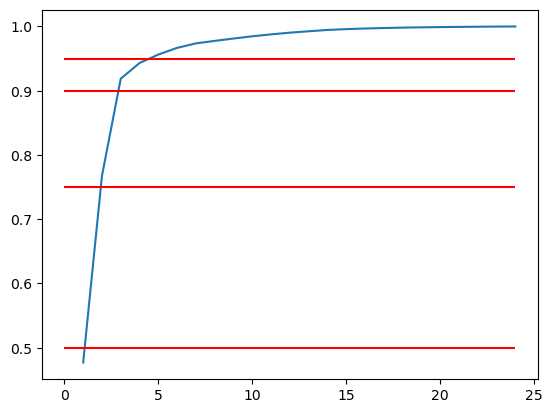

In [56]:
ax = sns.lineplot(x=np.arange(1, len(evr)+1), y=np.cumsum(evr))
ax.hlines([0.5, 0.75, 0.9, 0.95], 0, 24, colors="red")

In [57]:
pcax = pd.DataFrame(fit.components_,
            columns=bl_norm.columns)  # shape: components x features. So a row is a PC and a column is a feature.

Basically, those key PCs are capturing overall tendencies, then seasonal tendencies, with the lower-priority weights being basically noise.

PC0 is overall temperature, with warmer sites including a slight tendency towards wet summer/dry winter. PC1 is overall precipitation, with the summer weighted a bit less. PC2 is precipitation seasonality, identifying wet winter/dry summer with some weight on warm winters. And PC3, the last of any major importance, is more specialized, weighted towards wet summer/dry spring/cold summer/warm winter.

<Axes: >

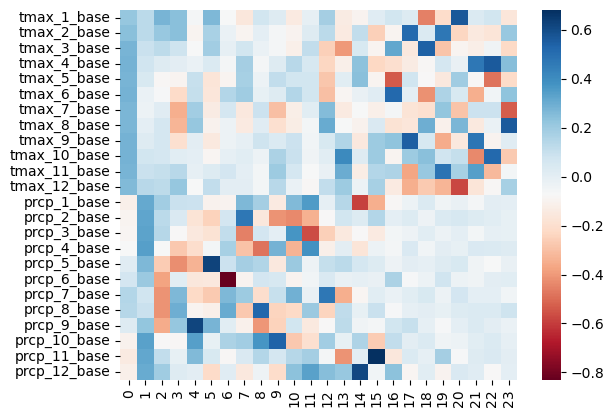

In [60]:
sns.heatmap(pcax.T, cmap="RdBu")

In [62]:
fit.components_[:4,]

array([[ 0.21586768,  0.23989016,  0.2746618 ,  0.28580839,  0.27976764,
         0.28286636,  0.27361166,  0.27268264,  0.28194208,  0.28259812,
         0.27770343,  0.25857542, -0.11702757, -0.09733902, -0.08768131,
        -0.07191027,  0.0170562 ,  0.06322824,  0.14500026,  0.14128204,
         0.02482924, -0.10768108, -0.14282257, -0.11823081],
       [ 0.13154684,  0.12773552,  0.09473307,  0.07619893,  0.04640758,
        -0.0262969 , -0.029786  ,  0.00150298,  0.02522516,  0.07033583,
         0.0935543 ,  0.13266506,  0.30972068,  0.32571088,  0.32989435,
         0.34168486,  0.26615413,  0.20897522,  0.07541591,  0.09300622,
         0.22689736,  0.33319007,  0.31932258,  0.30825848],
       [ 0.27974971,  0.21381692,  0.12481352,  0.02228264, -0.08273733,
        -0.06347236,  0.01588459,  0.06049041,  0.05960275,  0.06150123,
         0.10409225,  0.1257926 ,  0.18935833,  0.12722693,  0.1401273 ,
        -0.07149322, -0.26560643, -0.37798793, -0.41481308, -0.41089209,
  

In [64]:
bl_pc = bl_norm @ np.transpose(fit.components_[:4,])
bl_pc.columns = [f"bl_pc{x}" for x in range(4)]
bl_pc

bl_pc0    bl_pc1    bl_pc2    bl_pc3
id              year                                        
01010000        2012 -4.371772 -1.496358 -3.391764 -0.017522
                2013 -4.371772 -1.496358 -3.391764 -0.017522
                2014 -4.371772 -1.496358 -3.391764 -0.017522
                2015 -4.371772 -1.496358 -3.391764 -0.017522
                2016 -4.371772 -1.496358 -3.391764 -0.017522
...                        ...       ...       ...       ...
453004122510301 2019 -0.477569 -0.344762  2.763387  0.105640
                2020 -0.477569 -0.344762  2.763387  0.105640
                2021 -0.477569 -0.344762  2.763387  0.105640
                2022 -0.477569 -0.344762  2.763387  0.105640
                2023 -0.477569 -0.344762  2.763387  0.105640

[9053 rows x 4 columns]

## Anomaly PCA

We have a total of 24 anomaly values.

In [65]:
anom = preds.loc[:, "tmax_1_anom":"prcp_12_anom"]
offset = anom.mean()
scale = anom.std()
anom_norm = ((anom - offset)/scale).dropna()
anom_norm.describe()

,tmax_1_anom,tmax_2_anom,tmax_3_anom,tmax_4_anom,tmax_5_anom,tmax_6_anom,tmax_7_anom,tmax_8_anom,tmax_9_anom,tmax_10_anom,...,prcp_3_anom,prcp_4_anom,prcp_5_anom,prcp_6_anom,prcp_7_anom,prcp_8_anom,prcp_9_anom,prcp_10_anom,prcp_11_anom,prcp_12_anom
count,7031.000000,7031.000000,7031.000000,7031.000000,7031.000000,7031.000000,7031.000000,7031.000000,7031.000000,7031.000000,...,7031.000000,7031.000000,7031.000000,7031.000000,7031.000000,7031.000000,7031.000000,7031.000000,7031.000000,7031.000000
mean,0.003589,-0.000250,-0.008693,-0.008235,0.000124,0.003946,-0.001684,0.009555,0.010616,-0.036539,...,-0.002241,-0.002286,0.008068,-0.005597,0.004494,0.007018,0.006862,0.052925,-0.012404,-0.020444
std,0.984190,0.993439,0.971845,0.981925,0.984808,0.981931,0.989614,0.979812,0.986815,0.866246,...,1.004533,0.990880,0.996049,0.988273,0.995329,0.965321,1.010881,0.904100,0.994583,0.987229
min,-5.078144,-4.552463,-3.699859,-7.370694,-2.992455,-3.485764,-3.274596,-4.913581,-4.782619,-4.661575,...,-5.585458,-4.418966,-4.007855,-3.848461,-3.366994,-4.108085,-3.519232,-4.556979,-7.285416,-6.515964
25%,-0.685576,-0.590569,-0.677991,-0.582243,-0.688943,-0.631852,-0.597939,-0.631231,-0.656482,-0.594577,...,-0.479909,-0.585276,-0.584597,-0.570244,-0.541447,-0.485775,-0.577234,-0.453653,-0.547505,-0.470601
50%,-0.061167,0.026766,-0.056627,0.009307,0.048319,-0.009035,0.084228,-0.010463,-0.075683,-0.044641,...,-0.090577,-0.076693,-0.082171,-0.113522,-0.068598,-0.061937,-0.121630,-0.047178,-0.102332,-0.044861
75%,0.709095,0.640051,0.601537,0.577659,0.644418,0.534610,0.685371,0.627130,0.698540,0.547751,...,0.363557,0.536629,0.525676,0.430763,0.420168,0.372961,0.448380,0.447377,0.374549,0.390234
max,4.425059,3.127168,5.112049,3.808421,5.113643,4.189583,4.282854,5.119998,3.615611,5.401306,...,6.365493,6.040682,7.946529,15.975566,13.195533,13.427020,11.211653,8.982491,8.989220,5.994285


In [66]:
offset.to_dict()

{'tmax_1_anom': 1.8660196714101467e-17,
 'tmax_2_anom': 2.1588885513667475e-18,
 'tmax_3_anom': -2.77800792137257e-17,
 'tmax_4_anom': -1.5046585038482276e-18,
 'tmax_5_anom': 6.855633758889987e-17,
 'tmax_6_anom': 1.2565133728950678e-16,
 'tmax_7_anom': -1.682038833636812e-16,
 'tmax_8_anom': -4.93147069353453e-17,
 'tmax_9_anom': -5.568388386733527e-17,
 'tmax_10_anom': -6.857473513060945e-17,
 'tmax_11_anom': -5.1033121168342616e-17,
 'tmax_12_anom': 7.22521940100314e-18,
 'prcp_1_anom': 2.3119866369043957e-17,
 'prcp_2_anom': -6.94345236790927e-18,
 'prcp_3_anom': -6.496954009661655e-18,
 'prcp_4_anom': 8.598048593418444e-19,
 'prcp_5_anom': 1.6401919476914218e-17,
 'prcp_6_anom': 1.5602573080783797e-17,
 'prcp_7_anom': 4.914545978647434e-18,
 'prcp_8_anom': 8.475965254512473e-18,
 'prcp_9_anom': -3.659372882825801e-18,
 'prcp_10_anom': 1.5836114680585658e-17,
 'prcp_11_anom': -3.2337819354197302e-18,
 'prcp_12_anom': 7.32993272565536e-18}

In [67]:
scale.to_dict()

{'tmax_1_anom': 1.8865622437014982,
 'tmax_2_anom': 2.6489118588883036,
 'tmax_3_anom': 2.4124290735657565,
 'tmax_4_anom': 1.7332918291240935,
 'tmax_5_anom': 1.785213705773167,
 'tmax_6_anom': 1.4957331626288741,
 'tmax_7_anom': 1.4247602725367223,
 'tmax_8_anom': 1.1960909657839338,
 'tmax_9_anom': 1.5634106015710973,
 'tmax_10_anom': 2.061096083517126,
 'tmax_11_anom': 2.2480926141933715,
 'tmax_12_anom': 2.194900381510665,
 'prcp_1_anom': 2.3031507187082725,
 'prcp_2_anom': 2.314468092512231,
 'prcp_3_anom': 1.9739339127160076,
 'prcp_4_anom': 1.6877027601247405,
 'prcp_5_anom': 1.6366839253377363,
 'prcp_6_anom': 1.6172152019676318,
 'prcp_7_anom': 1.3403751362163792,
 'prcp_8_anom': 1.5846188488298198,
 'prcp_9_anom': 2.0081031910512155,
 'prcp_10_anom': 2.1791226360882248,
 'prcp_11_anom': 1.8925877913666387,
 'prcp_12_anom': 2.1864108301746836}

In [68]:
pca = PCA()
fit = pca.fit(anom_norm)
evr = fit.explained_variance_ratio_
print(evr)
print(np.cumsum(evr))

[0.12755621 0.08601596 0.07921916 0.06624665 0.06286807 0.0545968
 0.04991846 0.04575816 0.04184552 0.04004152 0.03949985 0.03546184
 0.03514111 0.03164357 0.03003553 0.02890474 0.02386205 0.02119473
 0.02074729 0.01876502 0.01758675 0.01585014 0.01406736 0.01317351]
[0.12755621 0.21357217 0.29279133 0.35903799 0.42190606 0.47650286
 0.52642131 0.57217947 0.614025   0.65406651 0.69356636 0.7290282
 0.7641693  0.79581287 0.82584841 0.85475315 0.8786152  0.89980993
 0.92055722 0.93932224 0.95690899 0.97275913 0.98682649 1.        ]


Here, the variance is much more spread out, though not entirely evenly distributed; it's not noise. 50% of variance is explained by 7 PCs, 75% by 13, 90% by 19, and 95% by 21.

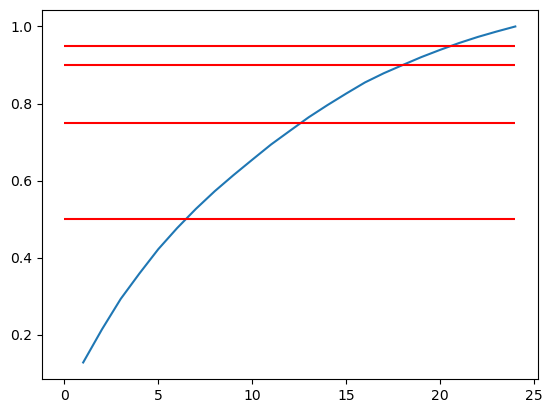

In [69]:
ax = sns.lineplot(x=np.arange(1, len(evr)+1), y=np.cumsum(evr))
ax.hlines([0.5, 0.75, 0.9, 0.95], 0, 24, colors="red")

In [70]:
pcax = pd.DataFrame(fit.components_,
            columns=anom_norm.columns)  # shape: components x features. So a row is a PC and a column is a feature.

The weights are rather noisy, but do have some tendencies. PC0 is a warm and dry late spring/early summer. PC1 is most heavily weighted towards a warm summer, but includes a dry late fall. (That is interesting, noting that we are still speaking of water years here. That means a dry Oct-Dec of one calendar year tends to co-occur with a warm summer of the following calendar year.)

Noting that we *can* fit all 24 coefficients with the available data, I'm inclined to just skip the PCA for anomalies, given how noisy it is. Or we could use the first 19. It's a little compression, at least.

<Axes: >

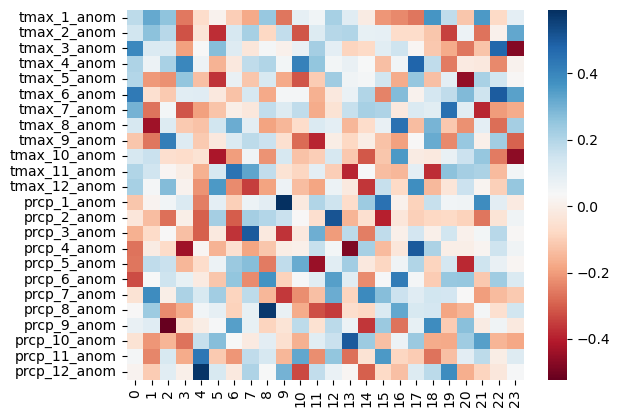

In [71]:
sns.heatmap(pcax.T, cmap="RdBu")

In [72]:
fit.components_[:19,]

array([[ 1.78448251e-01,  1.42709343e-01,  3.95463780e-01,
         2.08135443e-01,  1.98240525e-01,  4.26967297e-01,
         2.95903767e-01,  1.26097507e-01, -1.19611786e-01,
         1.27733177e-01,  2.01187014e-01,  2.18794091e-01,
        -1.18430122e-01, -3.30709761e-02, -1.61873524e-01,
        -2.66035665e-01, -2.64834974e-01, -3.29201348e-01,
        -4.47227019e-02,  3.10711344e-02,  7.74043235e-02,
        -4.73086655e-02,  4.54544152e-02,  1.33724790e-02],
       [ 3.20460446e-01,  2.60926901e-01,  1.14116091e-01,
         6.79676211e-02, -2.08912198e-01, -5.54946670e-02,
        -2.67133220e-01, -4.37442327e-01, -2.63705331e-01,
         1.56966021e-01,  1.45365418e-01,  4.44699971e-02,
         1.51338243e-02, -1.36097365e-01, -7.24610755e-02,
        -1.24256899e-02,  1.75981445e-01,  3.70865529e-02,
         3.84371972e-01,  2.38485394e-01,  1.03381736e-01,
        -2.13513894e-01, -2.37517761e-01, -1.05088454e-01],
       [ 2.58176242e-01,  1.87981020e-01,  1.17008107e

In [74]:
anom_pc = anom_norm @ np.transpose(fit.components_[:19,])
anom_pc.columns = [f"anom_pc{x}" for x in range(19)]
anom_pc

anom_pc0  anom_pc1  anom_pc2  anom_pc3  anom_pc4  \
id              year                                                     
01010000        2013  0.862635  1.176516  0.303238 -1.097591 -0.696476   
                2014 -0.234772 -0.123979 -0.493781 -0.108658  0.916996   
                2015 -0.735547 -1.335546  0.258103  0.941805 -0.019289   
01011000        2011 -0.704516  0.692537 -0.249149 -1.359372  0.365529   
                2012  2.061185 -0.371495  1.189792 -0.917763 -1.039752   
...                        ...       ...       ...       ...       ...   
453004122510301 2018  1.374514 -0.955138 -0.078863 -0.563986 -0.460641   
                2019  1.007363  1.074358 -1.965563  0.945749  0.181560   
                2020 -0.215171  1.115756  0.995532  1.633286 -1.188070   
                2021  2.746152 -0.393803  0.026863  1.933568 -0.297821   
                2022 -1.312336 -0.931418  1.885585 -2.235761  0.501171   

                      anom_pc5  anom_pc6  anom_pc7  anom_pc8  anom_pc9  \
id              year                                                     
01010000        2013  0.200588  0.487798 -0.292667  0.457479  0.717262   
                2014 -0.850899 -0.638992  1.014625 -0.349854  0.045672   
                2015  0.730801 -0.016739 -0.751333 -0.200252 -0.766225   
01011000        2011  1.297878 -0.551967  1.199158  1.093107 -0.248936   
                2012  0.013559  1.841276 -0.388217  0.850379  0.872895   
...                        ...       ...       ...       ...       ...   
453004122510301 2018 -1.172236 -0.238094 -1.389654  0.577963 -0.660493   
                2019  0.662833  0.068206 -1.522176 -0.536471 -0.459289   
                2020  0.265782  1.241712 -0.812255  0.372017  0.707608   
                2021 -0.165662 -0.568402 -0.261543  0.214598  1.206664   
                2022  0.830125  1.555537  0.011577 -0.082508  0.138017   

                      anom_pc10  anom_pc11  anom_pc12  anom_pc13  anom_pc14  \
id              year                                                          
01010000        2013   0.248385   0.328866   0.766819   1.606443  -0.446936   
                2014   0.297192   0.422721  -0.349599  -0.334285   0.991052   
                2015  -0.871461  -0.650636  -0.062884  -0.585034  -0.211901   
01011000        2011   0.266748  -1.329731  -0.892143   0.148344   0.040811   
                2012   0.484406   1.449703   0.107623  -0.264690   0.094194   
...                         ...        ...        ...        ...        ...   
453004122510301 2018   0.497089   0.001956   0.087631  -0.317716   1.311131   
                2019   0.196642   0.291944   0.111731  -0.399126  -0.548277   
                2020  -0.177800   0.466641  -0.703527   0.613267   0.117703   
                2021   1.231269  -0.595596   0.538979   0.013639   0.172607   
                2022   0.207069  -0.953013   0.337999  -1.003677   0.515156   

                      anom_pc15  anom_pc16  anom_pc17  anom_pc18  
id              year                                              
01010000        2013  -0.217655   0.225601   0.654768  -0.887178  
                2014  -0.532675   0.342398  -0.849647   0.192320  
                2015   0.331769  -0.548104   0.507001   0.269290  
01011000        2011   0.416952  -0.101665   0.498144   0.458265  
                2012  -0.173132   0.454292   0.398269  -0.107446  
...                         ...        ...        ...        ...  
453004122510301 2018   0.775426  -0.094387   0.148134   0.199261  
                2019  -1.002350  -0.020575   0.500296  -0.070389  
                2020   0.113697  -0.452719  -0.214346   0.579077  
                2021   0.251286   0.384882  -0.137938   1.280610  
                2022   0.004186   0.489330  -0.552104   0.343326  

[7031 rows x 19 columns]

# Linear Model

With all monthly baselines and anomalies, we have a total of 48 predictors and 8,000 observations, or almost 200 observations per coefficient. So even an "everything" model is statistically reasonable. However, PCA reduced that to 23 predictors (19 anomaly, 4 baseline). Even better.

In [75]:
mdata = coefs_yr.loc[:, "Amplitude":"sensitivity"].merge(bl_pc, on=["id", "year"]).merge(anom_pc, on=["id", "year"])

In [76]:
mdata

Amplitude  FallWinter  Intercept  SpringSummer  \
id              year                                                   
01010000        2013  -0.523222   -0.540827  -0.183049      0.290408   
                2014   0.152114    0.310228  -0.067034      0.199020   
                2015   0.343451    0.203889   0.251004      0.430718   
01011000        2011  -0.398255    0.014615  -0.581494      0.938985   
                2012   0.278617   -0.241342   0.624210     -0.738517   
...                         ...         ...        ...           ...   
453004122510301 2018  -0.138076    1.560369   0.136147      0.323443   
                2019   0.448157   -0.024682   0.147766     -0.200000   
                2020  -0.354094    0.467723   0.074132      0.561227   
                2021   0.575161    0.328937   0.845693     -0.061317   
                2022   0.618139   -0.672863   0.635013      1.965573   

                      WinterDay  sensitivity    bl_pc0    bl_pc1    bl_pc2  \
id              year                                                         
01010000        2013        0.0     0.026177 -4.371772 -1.496358 -3.391764   
                2014       -0.5     0.016199 -4.371772 -1.496358 -3.391764   
                2015        0.0    -0.079102 -4.371772 -1.496358 -3.391764   
01011000        2011        0.0     0.114244 -3.878755 -1.070683 -3.039380   
                2012        0.0    -0.078741 -3.878755 -1.070683 -3.039380   
...                         ...          ...       ...       ...       ...   
453004122510301 2018      -59.0     0.074364 -0.477569 -0.344762  2.763387   
                2019        3.0    -0.071707 -0.477569 -0.344762  2.763387   
                2020       25.0     0.114515 -0.477569 -0.344762  2.763387   
                2021       22.0     0.072769 -0.477569 -0.344762  2.763387   
                2022       -1.0     0.112358 -0.477569 -0.344762  2.763387   

                        bl_pc3  ...  anom_pc9  anom_pc10  anom_pc11  \
id              year            ...                                   
01010000        2013 -0.017522  ...  0.717262   0.248385   0.328866   
                2014 -0.017522  ...  0.045672   0.297192   0.422721   
                2015 -0.017522  ... -0.766225  -0.871461  -0.650636   
01011000        2011 -0.044053  ... -0.248936   0.266748  -1.329731   
                2012 -0.044053  ...  0.872895   0.484406   1.449703   
...                        ...  ...       ...        ...        ...   
453004122510301 2018  0.105640  ... -0.660493   0.497089   0.001956   
                2019  0.105640  ... -0.459289   0.196642   0.291944   
                2020  0.105640  ...  0.707608  -0.177800   0.466641   
                2021  0.105640  ...  1.206664   1.231269  -0.595596   
                2022  0.105640  ...  0.138017   0.207069  -0.953013   

                      anom_pc12  anom_pc13  anom_pc14  anom_pc15  anom_pc16  \
id              year                                                          
01010000        2013   0.766819   1.606443  -0.446936  -0.217655   0.225601   
                2014  -0.349599  -0.334285   0.991052  -0.532675   0.342398   
                2015  -0.062884  -0.585034  -0.211901   0.331769  -0.548104   
01011000        2011  -0.892143   0.148344   0.040811   0.416952  -0.101665   
                2012   0.107623  -0.264690   0.094194  -0.173132   0.454292   
...                         ...        ...        ...        ...        ...   
453004122510301 2018   0.087631  -0.317716   1.311131   0.775426  -0.094387   
                2019   0.111731  -0.399126  -0.548277  -1.002350  -0.020575   
                2020  -0.703527   0.613267   0.117703   0.113697  -0.452719   
                2021   0.538979   0.013639   0.172607   0.251286   0.384882   
                2022   0.337999  -1.003677   0.515156   0.004186   0.489330   

                      anom_pc17  anom_pc18  
id              year                        
01010000        2013   0.654

In [77]:
X = mdata.loc[:, "bl_pc0":]
allvar = X.columns
allvref = allvar
Y = mdata.loc[:, :"sensitivity"]

That "everything model" actually does quite well for several variables, and that should generalize given the mass of data. We get an R2 of 0.39 for Amplitude, 0.56 (!) for Intercept, and even 0.25-0.28 for the two anomaly coefficients.

In [79]:
# Reference linear model
Xnp = np.concatenate((np.ones((len(X), 1)), X.to_numpy()), axis=1)
lfit = np.linalg.lstsq(Xnp, Y, rcond=None)[0]
prd = Xnp @ lfit
refwt = pd.concat([
    pd.DataFrame({"R2": np.corrcoef(Y.iloc[:, i], prd[:, i])[0, 1]**2}, index=[Y.columns[i]])
    for i in range(len(Y.columns))
])
refwt

,R2
Amplitude,0.391340
FallWinter,0.245578
Intercept,0.555698
SpringSummer,0.281228
WinterDay,0.134421
sensitivity,0.064674


In [87]:
fit_df = pd.DataFrame(lfit, columns=Y.columns, index=['intercept'] + X.columns.to_list())
fit_df

,Amplitude,FallWinter,Intercept,SpringSummer,WinterDay,sensitivity
intercept,-0.000459,0.204745,0.008418,0.271701,-1.807897,0.000744
bl_pc0,0.001248,0.015537,0.000063,0.011311,-1.300774,-0.000176
bl_pc1,-0.000483,0.025355,0.002975,-0.005938,-0.581827,-0.000385
bl_pc2,-0.001804,-0.011756,-0.002161,-0.020517,-0.796425,0.000462
bl_pc3,-0.000414,-0.025635,-0.000459,-0.010071,0.532362,0.000557
anom_pc0,0.024855,0.039043,0.230980,-0.089564,1.467652,0.001850
anom_pc1,-0.181699,0.035313,0.037730,-0.048909,1.615915,0.002479
anom_pc2,-0.118796,-0.025035,0.087277,0.097138,2.122255,0.000010
anom_pc3,0.113790,-0.038049,-0.058581,-0.193695,0.893964,-0.002002
anom_pc4,0.006930,-0.059017,-0.005274,-0.034664,2.152591,0.002210
